# Value at risk

VaR is measure of potential loss at a specific confidence interval. A VAR statistic has three components: a time period, a confidence level and a loss amount (or loss percentage). What is the most I can - with a 95% or 99% level of confidence - expect to lose in dollars over the next month? There are 3 ways to compute Value at risk
# 

+ **Historical Method**: The historical method simply re-organizes actual historical returns, putting them in order from worst to best.
+ **The Variance-Covariance Method**: This method assumes that stock returns are normally distributed and use pdf instead of actual returns.
+ **Monte Carlo Simulation**: This method involves developing a model for future stock price returns and running multiple hypothetical trials.

## Stages for monte carlo simulation

This demo covers multiple stages:
# 

+ STAGE1: Using Delta Lake for a curated and a 360 view of your risk portfolio
+ STAGE2: Tracking experiments and registering risk models through MLflow capabilities
+ STAGE3: Leveraging the power of Apache Spark for massively distributed Monte Carlo simulations
+ STAGE4: Slicing and dicing through your risk exposure using collaborative notebooks and SQL
+ STAGE5: Acquiring news analytics data as a proxy of market volatility
+ STAGE6: Reporting breaches through model risk backtesting

### Dependencies

This series of notebooks require the following dependencies
- `com.aamend.spark:spark-gdelt:2.0`
- `yfinance`
- `mlflow`

## Authors
- Antoine Amend [<antoine.amend@databricks.com>]

# `VAR 101`

We report in below example a simple Value at risk calculation for a synthetic instrument, given a volatility (i.e. standard deviation of instrument returns) and a time horizon (300 days). 
What is the most I could lose in 300 days with a 95% confidence?

In [3]:
# time horizon
days = 300
dt = 1/float(days)

# volatility
sigma = 0.04 

# drift (average growth rate)
mu = 0.05  

# initial starting price
start_price = 10

# number of simulations
runs_gr = 500
runs_mc = 10000

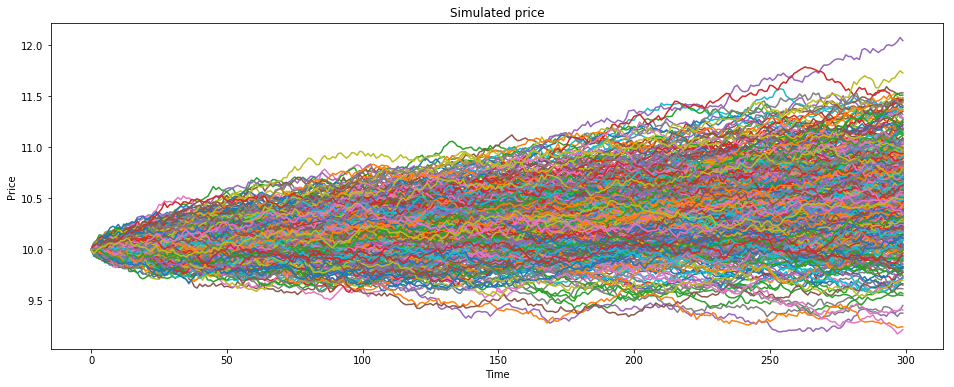

In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def generate_prices(start_price):
    shock = np.zeros(days)
    price = np.zeros(days)
    price[0] = start_price
    for i in range(1, days):
        shock[i] = np.random.normal(loc=mu * dt, scale=sigma * np.sqrt(dt))
        price[i] = max(0, price[i - 1] + shock[i] * price[i - 1])
    return price

plt.figure(figsize=(16,6))
for i in range(1, runs_gr):
    plt.plot(generate_prices(start_price))

plt.title('Simulated price')
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

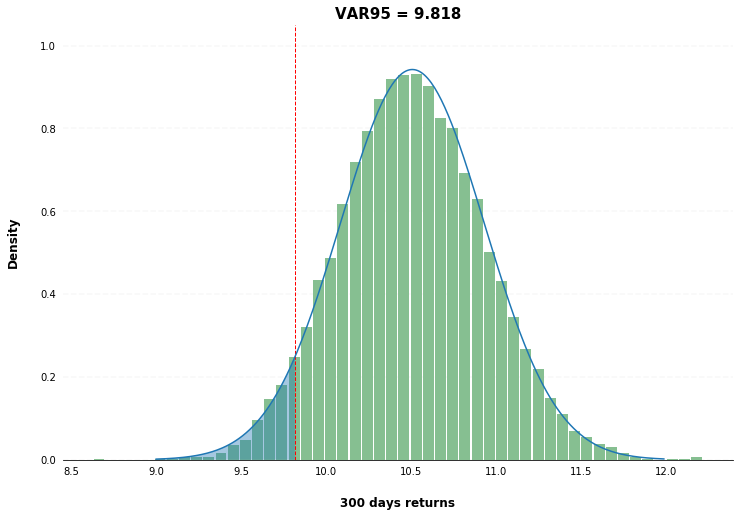

In [5]:
simulations = np.zeros(runs_mc)
for i in range(0, runs_mc):
    simulations[i] = generate_prices(start_price)[days - 1]
    
mean = simulations.mean()
z = stats.norm.ppf(1-0.95)
m1 = simulations.min()
m2 = simulations.max()
std = simulations.std()
q1 = np.percentile(simulations, 5) # VAR95

x1 = np.arange(9,12,0.01)
y1 = stats.norm.pdf(x1, loc=mean, scale=std)
x2 = np.arange(x1.min(),q1,0.001)
y2 = stats.norm.pdf(x2, loc=mean, scale=std)

mc_df = pd.DataFrame(data = simulations, columns=['return'])
ax = mc_df.hist(column='return', bins=50, density=True, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
ax = ax[0]

for x in ax:
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)
    x.axvline(x=q1, color='r', linestyle='dashed', linewidth=1)
    x.fill_between(x2, y2, zorder=3, alpha=0.4)
    x.plot(x1, y1, zorder=3)
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    x.set_title("VAR95 = {:.3f}".format(q1), weight='bold', size=15)
    x.set_xlabel("{} days returns".format(days), labelpad=20, weight='bold', size=12)
    x.set_ylabel("Density", labelpad=20, weight='bold', size=12)
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))